In [1]:
import os
import sys
import logging #nice message
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt #display image
import cv2 #for image resize
import tqdm #give a nice process bar visualization
import random
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [9]:
DATA_DIR = ".././model/datas/"
IMG_SIZE = 255
NUM_CLASSES = 2
TEST_SIZE = 0.5
BATCH_SIZE = 64
NO_EPOCHS = 20
SAMPLE_SIZE = 100

In [29]:
def label_pet_image_one_hot_encoder(img):
    """
    img is a filename
    """
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm.tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    random.shuffle(data_df)
    return data_df

def plot_image_list_count(data_image_list):
    labels = []
    categoral = defaultdict(int)
    for img in data_image_list:
        classname = img.split('.')[-3]
        categoral[classname] += 1
    df = pd.DataFrame.from_dict(categoral,orient='index')
    df.plot.bar()
    plt.show()

def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(10,10))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()



In [10]:
if not os.path.exists(DATA_DIR):
    logging.error(f"{DATA_DIR} not found")


In [24]:
raw_data_file = os.path.join(DATA_DIR,"dogs-vs-cats")
test_dir = os.path.join(raw_data_file,"test1")
train_dir = os.path.join(raw_data_file,"train")
#plot_image_list_count(os.listdir(train_dir))

train = process_data(os.listdir(train_dir)[:SAMPLE_SIZE],train_dir)
test = process_data(os.listdir(test_dir),test_dir,False)
#show_images(train)
#show_images(test,True)

#convert training data to numpy array X and Y
X, Y = zip(*train)
X = [np.array(x).reshape(IMG_SIZE,IMG_SIZE,3) for x in X]
X = np.array(X)

Y = np.array(Y)

#use ResNet-50
model = keras.Sequential()
model.add(keras.applications.ResNet50(include_top=False,pooling='max'))
model.add(keras.layers.Dense(NUM_CLASSES,activation="softmax"))
model.layers[0].trainable = False
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


100%|███████████████████████████████████| 12500/12500 [00:08<00:00, 1454.47it/s]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [25]:
 #prepare data for training
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=TEST_SIZE)

In [26]:
X_train.shape, y_train.shape

((50, 255, 255, 3), (50, 2))

Epoch 1/20
1/1 [==============================] - 1s 822ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy: 0.9800
Epoch 2/20
1/1 [==============================] - 1s 762ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy: 0.9800
Epoch 3/20
1/1 [==============================] - 1s 755ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy: 0.9800
Epoch 4/20
1/1 [==============================] - 1s 754ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy: 0.9800
Epoch 5/20
1/1 [==============================] - 1s 753ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy: 0.9800
Epoch 6/20
1/1 [==============================] - 1s 755ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy: 0.9800
Epoch 7/20
1/1 [==============================] - 1s 756ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy:

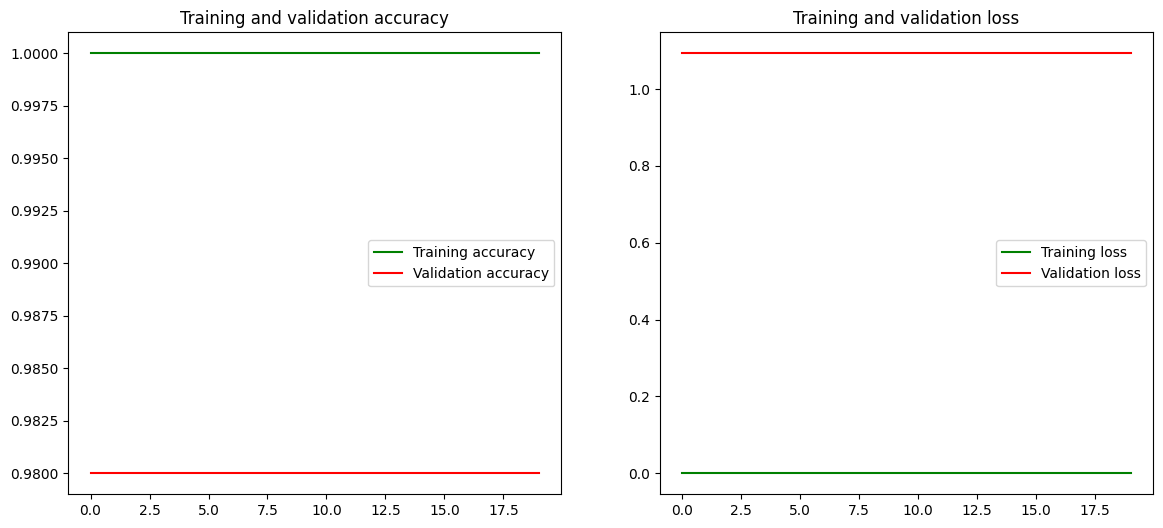

In [30]:

            
            
#Train with validation
train_model = model.fit(X_train, y_train,
      batch_size=BATCH_SIZE,
      epochs=NO_EPOCHS,
      verbose=1,
      validation_data=(X_val, y_val))

plot_accuracy_and_loss(train_model)

            

Validation loss: 1.0931141376495361
Validation accuracy: 0.9800000190734863
2/2 [==============================] - 0s 239ms/step
              precision    recall  f1-score   support

    Class 0:       1.00      0.95      0.98        21
    Class 1:       0.97      1.00      0.98        29

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

1/1 [==============================] - 0s 17ms/step
end


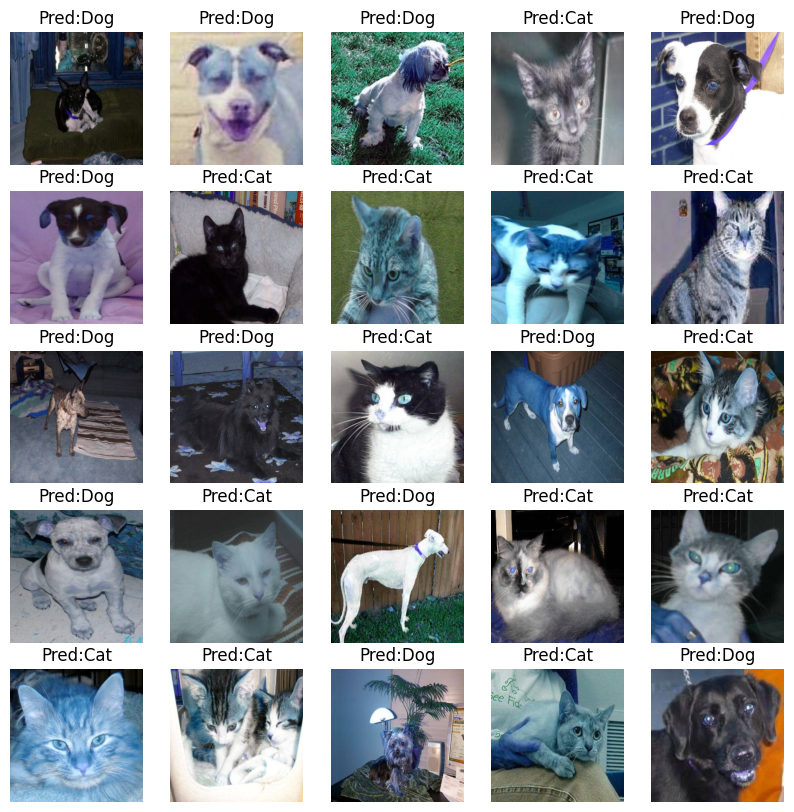

In [79]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

#get the predictions for the test data
predicted_classes =  np.argmax(model.predict(X_val), axis=1)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

f, ax = plt.subplots(5,5, figsize=(10,10))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict(data)[0]

    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'

    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Pred:{}".format(str_predicted)) 
print("end")


In [88]:
keras_save_model = ".././model/my_model.h5"
model.save(keras_save_model)

/Users/yueyangxie/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


2023-09-19 15:55:54.527008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 17ms/step
end


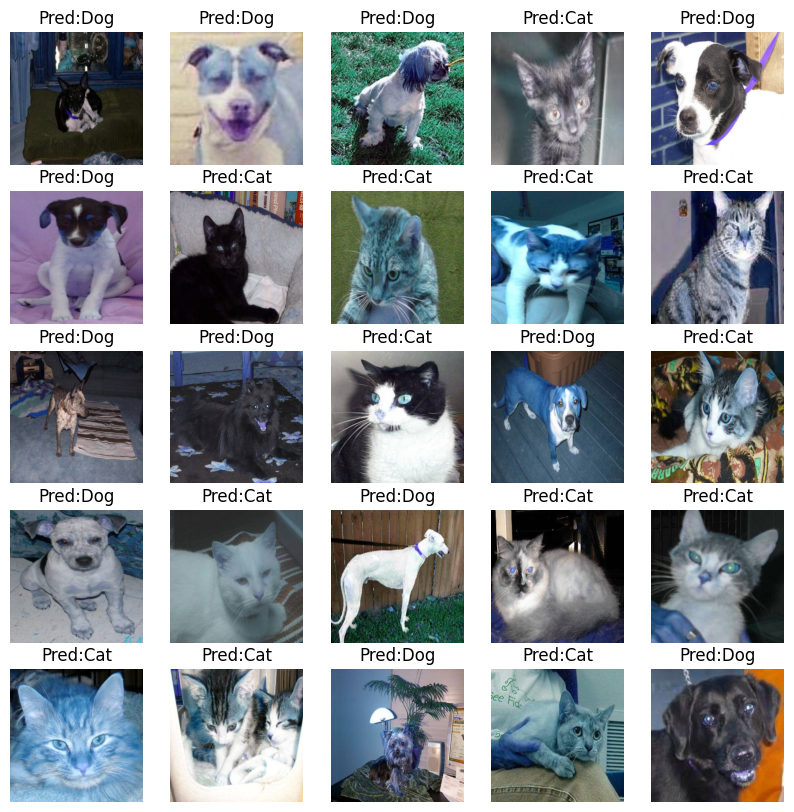

In [91]:
newModel = keras.models.load_model(keras_save_model)
newModel.summary()


f, ax = plt.subplots(5,5, figsize=(10,10))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = newModel.predict(data)[0]

    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'

    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Pred:{}".format(str_predicted)) 
print("end")
